In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
data = "Data/nfl_stadiums.csv"
data2 = "Data/nfl_teams.csv"
data3 = "Data/spreadspoke_scores.csv"

dfstad = pd.read_csv(data, encoding="unicode_escape")
dfteam = pd.read_csv(data2)
dfscore = pd.read_csv(data3)

<IPython.core.display.Javascript object>

In [5]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12934 non-null  object 
 1   schedule_season      12934 non-null  int64  
 2   schedule_week        12934 non-null  object 
 3   schedule_playoff     12934 non-null  bool   
 4   team_home            12934 non-null  object 
 5   score_home           12797 non-null  float64
 6   score_away           12797 non-null  float64
 7   team_away            12934 non-null  object 
 8   team_favorite_id     10318 non-null  object 
 9   spread_favorite      10318 non-null  float64
 10  over_under_line      10308 non-null  object 
 11  stadium              12934 non-null  object 
 12  stadium_neutral      12934 non-null  bool   
 13  weather_temperature  12008 non-null  float64
 14  weather_wind_mph     12008 non-null  float64
 15  weather_humidity     8388 non-null  

<IPython.core.display.Javascript object>

In [6]:
dfscore = dfscore.replace(r"^\s*$", np.nan, regex=True)
dfscore = dfscore.drop(
    columns=[
        "weather_humidity",
        "weather_detail",
        "weather_temperature",
        "weather_wind_mph",
        "schedule_date",
        "schedule_playoff",
        "stadium",
        "stadium_neutral",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
dfscore = dfscore[
    (dfscore["score_home"].isna() == False)
    & (dfscore["team_favorite_id"].isna() == False)
    & (dfscore["over_under_line"].isna() == False)
    & (dfscore["schedule_season"] >= 1979)
]

<IPython.core.display.Javascript object>

In [8]:
dfscore.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10234 entries, 0 to 10233
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   schedule_season   10234 non-null  int64  
 1   schedule_week     10234 non-null  object 
 2   team_home         10234 non-null  object 
 3   score_home        10234 non-null  float64
 4   score_away        10234 non-null  float64
 5   team_away         10234 non-null  object 
 6   team_favorite_id  10234 non-null  object 
 7   spread_favorite   10234 non-null  float64
 8   over_under_line   10234 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 719.7+ KB


<IPython.core.display.Javascript object>

In [10]:
dfscore["over_under_line"] = dfscore["over_under_line"].astype(float)

<IPython.core.display.Javascript object>

In [11]:
dfscore["team_home"] = dfscore["team_home"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)
dfscore["team_away"] = dfscore["team_away"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)

<IPython.core.display.Javascript object>

In [12]:
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_home"], "home_favorite"] = 1
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_away"], "away_favorite"] = 1
dfscore["home_favorite"].fillna(0, inplace=True)
dfscore["away_favorite"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [13]:
dfscore.loc[
    ((dfscore["score_home"] + dfscore["score_away"]) > dfscore["over_under_line"]),
    "is_over",
] = 1
dfscore["is_over"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [14]:
pd.crosstab(dfscore["team_away"], dfscore["is_over"])

is_over,0.0,1.0
team_away,,
ARI,162,171
ATL,178,162
BAL,119,93
BUF,182,156
CAR,104,110
CHI,176,155
CIN,179,154
CLE,157,150
DAL,182,156


<IPython.core.display.Javascript object>

In [15]:
dfscore["total_pts"] = dfscore["score_home"] + dfscore["score_away"]

<IPython.core.display.Javascript object>

In [16]:
dfscore_copy = dfscore.copy()

<IPython.core.display.Javascript object>

In [17]:
dfscore.head()

,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,home_favorite,away_favorite,is_over,total_pts
0,1979,1,TB,31.0,16.0,DET,TB,-3.0,30.0,1.0,0.0,1.0,47.0
1,1979,1,BUF,7.0,9.0,MIA,MIA,-5.0,39.0,0.0,1.0,0.0,16.0
2,1979,1,CHI,6.0,3.0,GB,CHI,-3.0,31.0,1.0,0.0,0.0,9.0
3,1979,1,DEN,10.0,0.0,CIN,DEN,-3.0,31.5,1.0,0.0,0.0,10.0
4,1979,1,KC,14.0,0.0,IND,KC,-1.0,37.0,1.0,0.0,0.0,14.0


<IPython.core.display.Javascript object>

In [18]:
dfscore.loc[(dfscore.schedule_week == "18"), "schedule_week"] = "17"
dfscore.loc[
    (dfscore.schedule_week == "Wildcard") | (dfscore.schedule_week == "WildCard"),
    "schedule_week",
] = "18"
dfscore.loc[(dfscore.schedule_week == "Division"), "schedule_week"] = "19"
dfscore.loc[(dfscore.schedule_week == "Conference"), "schedule_week"] = "20"
dfscore.loc[
    (dfscore.schedule_week == "Superbowl") | (dfscore.schedule_week == "SuperBowl"),
    "schedule_week",
] = "21"
dfscore["schedule_week"] = dfscore.schedule_week.astype(int)

<IPython.core.display.Javascript object>

In [19]:
dfscore["schedule_week"]

0        1
1        1
2        1
3        1
4        1
        ..
10229    8
10230    8
10231    8
10232    8
10233    8
Name: schedule_week, Length: 10234, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
dfss = dfscore[(dfscore["schedule_week"] >= 3) & (dfscore["schedule_week"] <= 15)]


<IPython.core.display.Javascript object>

In [21]:
dfss.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
schedule_season,7491.0,1999.948738,11.901220,1979.0,1990.0,2000.0,2010.0,2020.0
schedule_week,7491.0,9.143906,3.778176,3.0,6.0,9.0,12.0,15.0
score_home,7491.0,22.602590,10.338025,0.0,16.0,22.0,30.0,62.0
score_away,7491.0,20.083433,10.044513,0.0,13.0,20.0,27.0,59.0
spread_favorite,7491.0,-5.375784,3.463218,-26.5,-7.0,-4.5,-3.0,0.0
over_under_line,7491.0,42.042611,4.690212,30.0,38.5,42.0,45.0,63.5
home_favorite,7491.0,0.659992,0.473743,0.0,0.0,1.0,1.0,1.0
away_favorite,7491.0,0.325858,0.468726,0.0,0.0,0.0,1.0,1.0
is_over,7491.0,0.487118,0.499867,0.0,0.0,0.0,1.0,1.0
total_pts,7491.0,42.686023,14.280461,3.0,33.0,42.0,51.0,106.0


<IPython.core.display.Javascript object>

In [22]:
dfss.corr().style.background_gradient()

,schedule_season,schedule_week,score_home,score_away,spread_favorite,over_under_line,home_favorite,away_favorite,is_over,total_pts
schedule_season,1.000000,-0.037278,0.070198,0.109477,-0.006201,0.356315,-0.018342,0.033702,0.013018,0.127821
schedule_week,-0.037278,1.000000,-0.001086,-0.022030,-0.033686,-0.048003,-0.020175,0.019505,-0.009764,-0.016281
score_home,0.070198,-0.001086,1.000000,-0.018468,-0.134277,0.200810,0.220997,-0.214274,0.532846,0.710938
score_away,0.109477,-0.022030,-0.018468,1.000000,0.119338,0.210978,-0.238894,0.242468,0.518858,0.690005
spread_favorite,-0.006201,-0.033686,-0.134277,0.119338,1.000000,-0.039402,-0.213744,0.169165,-0.007694,-0.013268
over_under_line,0.356315,-0.048003,0.200810,0.210978,-0.039402,1.000000,-0.009192,0.015698,-0.033308,0.293768
home_favorite,-0.018342,-0.020175,0.220997,-0.238894,-0.213744,-0.009192,1.000000,-0.968641,-0.013142,-0.008046
away_favorite,0.033702,0.019505,-0.214274,0.242468,0.169165,0.015698,-0.968641,1.000000,0.017064,0.015427
is_over,0.013018,-0.009764,0.532846,0.518858,-0.007694,-0.033308,-0.013142,0.017064,1.000000,0.750694
total_pts,0.127821,-0.016281,0.710938,0.690005,-0.013268,0.293768,-0.008046,0.015427,0.750694,1.000000


<IPython.core.display.Javascript object>

In [23]:
print(dfss.columns)

Index(['schedule_season', 'schedule_week', 'team_home', 'score_home',
       'score_away', 'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'home_favorite', 'away_favorite', 'is_over',
       'total_pts'],
      dtype='object')


<IPython.core.display.Javascript object>

### Modeling 

In [24]:
X = dfss.drop(
    columns=[
        "is_over",
        "schedule_season",
        "over_under_line",
        "total_pts",
        "home_favorite",
        "away_favorite",
    ]
)
y = dfss["is_over"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [25]:
bin_cols = ["is_over"]  # "home_favorite", "away_favorite"#
num_cols = [
    "score_home",
    "score_away",
    "spread_favorite",
    # "over_under_line",
    # "total_pts",
]
cat_cols = [
    "schedule_week",
    "team_home",
    "team_favorite_id",
    "team_away",
]

prep = ColumnTransformer(
    [
        ("leave_one", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [37]:
transformed = prep.fit_transform(X_train, y_train)
# ToDO get printVIF and run it.
type(transformed)
# ToD0, create dataframe with transformed.
transformed = pd.DataFrame(transformed, columns=X_train.columns)
print_vif(transformed)

VIF results
-------------------------------
const               407.448782
schedule_week         1.002720
team_home             1.255179
score_home            1.264945
score_away            1.011093
team_away             1.022609
team_favorite_id      1.016258
spread_favorite       1.040043
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [27]:
# Try SVC
pipe = Pipeline([("prep", prep), ("svc", SVC())])

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.001, 0.01, 0.1, 1],
}

pipe_cv = GridSearchCV(pipe, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and Eval

In [28]:
pipe_cv.fit(X_train, y_train)

print("Best params:")
print(pipe_cv.best_params_)

print(f"\ntrain score: {pipe_cv.score(X_train,y_train):.3f}")
print(f"test score: {pipe_cv.score(X_test, y_test):.3f}\n")

y_pred = pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 0.001, 'svc__degree': 2, 'svc__kernel': 'linear'}

train score: 0.891
test score: 0.886

[[719  78]
 [ 93 609]]
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       797
         1.0       0.89      0.87      0.88       702

    accuracy                           0.89      1499
   macro avg       0.89      0.88      0.89      1499
weighted avg       0.89      0.89      0.89      1499



<IPython.core.display.Javascript object>

### Feature Importance 

In [29]:
# Turn back on if switches back to linear
# coef = pipe_cv.best_estimator_["svc"].coef_[0]
# im_df = pd.DataFrame({"feature": X_train.columns, "coef_sq": coef ** 2})
# im_df.sort_values("coef_sq", ascending=False)

<IPython.core.display.Javascript object>

### Error Analysis

In [30]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of over for errors: {errors["is_over"].mean()}')


# sns.swarmplot(y=errors["is_over"])
# plt.show()
# TODO predict_proba_

mean prob of over for errors: 0.543859649122807


<IPython.core.display.Javascript object>

### Try XGBoost

In [31]:
n_trees = 100
# learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)

x_pipe = Pipeline(
    [
        ("prep", prep),
        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
    ]
)

x_grid = {
    "xgb__subsample": [0.5, 0.75, 1],
    "xgb__colsample_bytree": [0.5, 0.75, 1],
    "xgb__max_depth": [2, 3, 4, 5],
}

x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

In [32]:
x_pipe_cv.fit(X_train, y_train)

print("Best params:")
print(x_pipe_cv.best_params_)

print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")

y_predx = x_pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_predx))
print(classification_report(y_test, y_predx))

/Users/JasonB/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 4, 'xgb__subsample': 0.5}

train score: 0.893
test score: 0.875

[[706  91]
 [ 96 606]]
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       797
         1.0       0.87      0.86      0.87       702

    accuracy                           0.88      1499
   macro avg       0.87      0.87      0.87      1499
weighted avg       0.88      0.88      0.88      1499



<IPython.core.display.Javascript object>

In [33]:
importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,features,importance
4,team_away,0.493233
5,team_favorite_id,0.403906
3,score_away,0.049657
1,team_home,0.047155
2,score_home,0.006049
0,schedule_week,0.000000
6,spread_favorite,0.000000


<IPython.core.display.Javascript object>

mean prob of over for errors: 0.5133689839572193


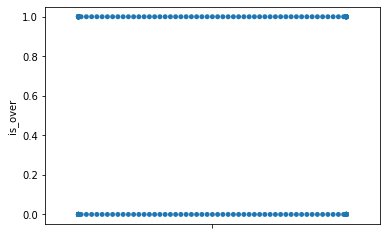

<IPython.core.display.Javascript object>

In [34]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_predx

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'mean prob of over for errors: {errors["is_over"].mean()}')


sns.swarmplot(y=errors["is_over"])
plt.show()

In [35]:
# for column_name in ['schedule_week', 'over_under_line']:
#    print("These are the problematic values for the variable: {}".format(column_name))
#    for value in dfscore[column_name]:
#        try:
#            float(value)
#        except:
#            print(value)

<IPython.core.display.Javascript object>

In [36]:
#pd.merge(sinfo_df[['Symbol', 'Sector', 'Industry', 'MarketCap']], snews_df[['Symbol', 'Sector', 'Industry']], on= ['Symbol', 'Sector', 'Industry'], how= 'outer')

# use concat when scraping and making for loops
#df_year to df_all
#df_all = [df_all, df_year]


<IPython.core.display.Javascript object>